In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
import symlib
import os
from glob import glob
from scipy.stats import linregress


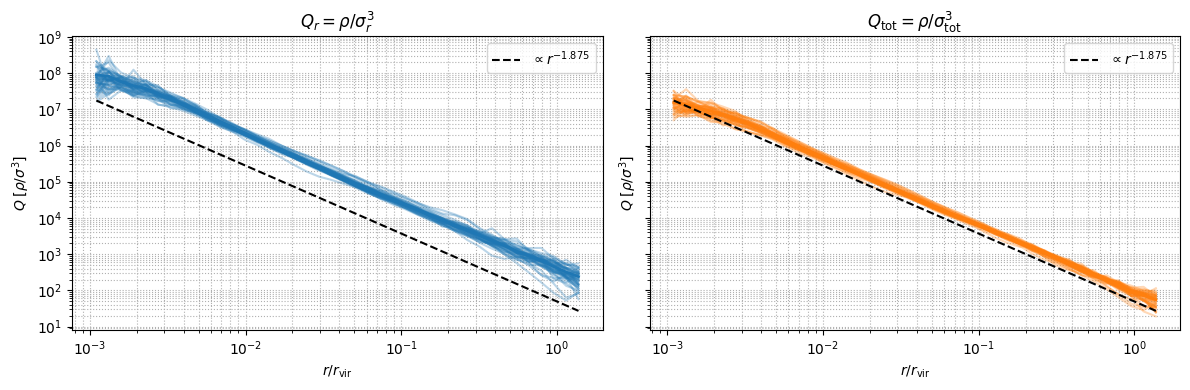

[Saved] PPSD profile figure saved.


In [ ]:

def ppsd_profiles(base_dir, suite_name):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])

    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    ppsd_r = []
    ppsd_tot = []

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values
        sigma_total = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q_r = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
            Q_tot = np.where(sigma_total > 0, rho / sigma_total**3, np.nan)

        ppsd_r.append(Q_r)
        ppsd_tot.append(Q_tot)

    ppsd_r = np.array(ppsd_r)
    ppsd_tot = np.array(ppsd_tot)
    r = df_rho["r_scaled"].values

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, dpi=500)

    for Q_arr in ppsd_r:
        axes[0].plot(r, Q_arr, alpha=0.3, color="C0")
    mean_r = np.nanmean(ppsd_r, axis=0)
    std_r = np.nanstd(ppsd_r, axis=0)
    axes[0].plot(r, mean_r, color="C0", lw=2)
    axes[0].fill_between(r, mean_r - std_r, mean_r + std_r, color="C0", alpha=0.3, linewidth=0.1)
    axes[0].set_title(r"$Q_r = \rho / \sigma_r^3$")

    for Q_arr in ppsd_tot:
        axes[1].plot(r, Q_arr, alpha=0.3, color="C1")
    mean_tot = np.nanmean(ppsd_tot, axis=0)
    std_tot = np.nanstd(ppsd_tot, axis=0)
    axes[1].plot(r, mean_tot, color="C1", lw=2)
    axes[1].fill_between(r, mean_tot - std_tot, mean_tot + std_tot, color="C1", alpha=0.3, linewidth=0.1)
    axes[1].set_title(r"$Q_{\rm tot} = \rho / \sigma_{\rm tot}^3$")

    for ax in axes:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
        ax.set_ylabel(r"$Q \; [\rho / \sigma^3]$")
        ax.grid(True, which="both", linestyle=":")

    r_ref = np.logspace(np.log10(r.min()), np.log10(r.max()), 100)
    norm_r = r_ref[10]  
    Q_ref = mean_r[10] * (r_ref / norm_r)**(-1.875)

    axes[0].plot(r_ref, Q_ref, 'k--', label=r"$\propto r^{-1.875}$")
    axes[1].plot(r_ref, Q_ref, 'k--', label=r"$\propto r^{-1.875}$")

    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "PPSD_profiles.png"))
    plt.show()
    print("[Saved] PPSD profile figure saved.")
    
ppsd_profiles("/Volumes/Atlas/Symphony", "SymphonyLMC")

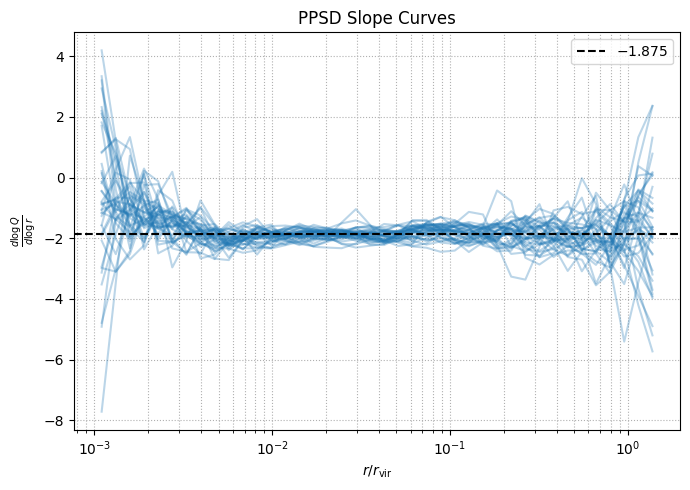

[Saved] All-halo PPSD slope figure saved.


In [ ]:

def plot_all_ppsd_slope_curves(base_dir, suite_name, window_width=0.1):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)

        log_r = np.log10(r)
        log_Q = np.log10(Q)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, _, _, _, _ = linregress(log_r[idx], log_Q[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C0")

    ax.axhline(-1.875, color='k', linestyle='--', label=r"$-1.875$")
    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log Q}{d\log r}$")
    ax.set_xscale("log")
    ax.set_title("PPSD Slope Curves")
    ax.grid(True, which="both", linestyle=":")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "PPSD_slope.png"))
    plt.show()
    print("[Saved] All-halo PPSD slope figure saved.")

plot_all_ppsd_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)

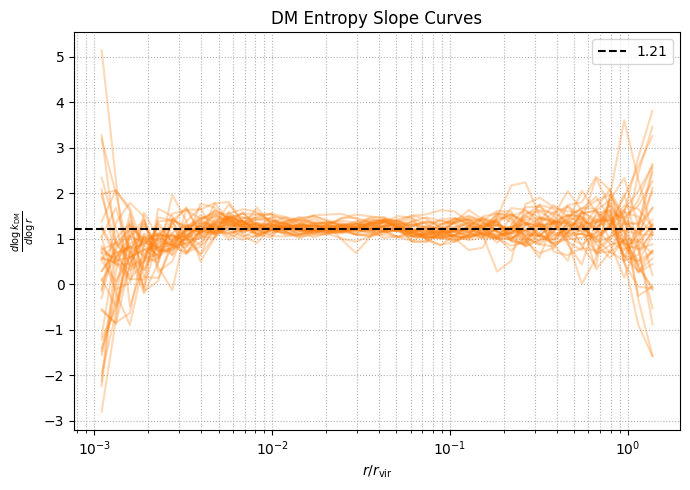

[Saved] Entropy slope figure saved.


In [27]:
def plot_entropy_slope_curves(base_dir, suite_name, window_width=0.3):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            entropy = np.where((rho > 0) & (sigma_tot > 0),
                               sigma_tot**2 * rho**(-2/3),
                               np.nan)

        # log–log slope of entropy
        log_r = np.log10(r)
        log_k = np.log10(entropy)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, *_ = linregress(log_r[idx], log_k[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C1")

    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log k_{\rm DM}}{d\log r}$")
    ax.set_title("DM Entropy Slope Curves")
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle=":")
    ax.axhline(1.21, color='k', linestyle='--', label="1.21")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "entropy_slope.png"))
    plt.show()
    print("[Saved] Entropy slope figure saved.")

plot_entropy_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_65799/1839960033.py:64: RuntimeWarning: Mean of empty slice
  mean_slope = np.nanmean(all_interp_slopes, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


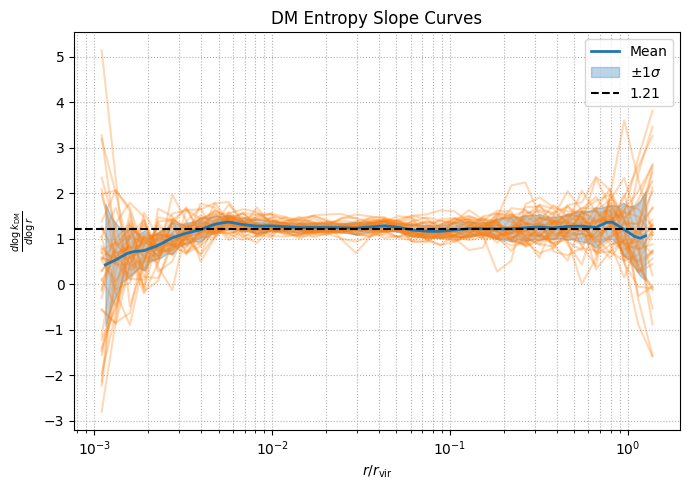

[Saved] Entropy slope figure with mean and 1σ saved.


In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.interpolate import interp1d

def plot_entropy_slope_curves(base_dir, suite_name, window_width=0.3):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    # 统一的插值半径范围
    r_interp = np.logspace(-3, 0.1, 100)
    all_interp_slopes = []

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            entropy = np.where((rho > 0) & (sigma_tot > 0),
                               sigma_tot**2 * rho**(-2/3),
                               np.nan)

        # log–log slope of entropy
        log_r = np.log10(r)
        log_k = np.log10(entropy)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, *_ = linregress(log_r[idx], log_k[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C1")

            try:
                interp_func = interp1d(np.log10(r[valid]), slopes[valid],
                                       kind="linear", bounds_error=False, fill_value=np.nan)
                interp_slopes = interp_func(np.log10(r_interp))
                all_interp_slopes.append(interp_slopes)
            except Exception as e:
                print(f"[Warning] Interpolation failed for one halo: {e}")

    # 计算均值和标准差
    all_interp_slopes = np.array(all_interp_slopes)
    mean_slope = np.nanmean(all_interp_slopes, axis=0)
    std_slope = np.nanstd(all_interp_slopes, axis=0)

    # 绘制平均曲线和 ±1σ 区间
    ax.plot(r_interp, mean_slope, color="C0", lw=2, label="Mean")
    ax.fill_between(r_interp, mean_slope - std_slope, mean_slope + std_slope,
                    color="C0", alpha=0.3, label=r"$\pm 1\sigma$")

    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log k_{\rm DM}}{d\log r}$")
    ax.set_title("DM Entropy Slope Curves")
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle=":")
    ax.axhline(1.21, color='k', linestyle='--', label="1.21")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "entropy_slope.png"))
    plt.show()
    print("[Saved] Entropy slope figure with mean and 1σ saved.")

# Example usage
plot_entropy_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)